# Quantum Walk on a Path Graph

Here, we will implement a quantum walk on a path graph with 16 nodes.

In [1]:
from classiq import *

A quantum walk can be executed by repeatedly applying the operator $\hat{U}_{QW}$ defined below.
$$
\ket{\psi(t)} = \hat{U}_{QW}^t \ket{\psi(0)}
$$
Given the graph $(V, E)$, we define the operators as follows:
$$
\begin{gather}
\hat{U}_{QW} = \hat{S}\hat{C} \\
\hat{C} = \sum_{j \in V}|j\rangle\langle j| \otimes\left(2\left|\partial_j\right\rangle\left\langle\partial_j\right|-I\right) \\
\hat{S} = \sum_{(j, k) \in E}|j, k\rangle\langle k, j| \\
\left|\partial_j\right\rangle=\frac{1}{\sqrt{\operatorname{deg}(j)}} \sum_{k:(j, k) \in E}|k\rangle
\end{gather}
$$
Now, let's implement each of these operators using Classiq.

First, we define the number of nodes in the graph. We consider 16 nodes, and since we encode them in binary, we need $\log_2 16 = 4$ qubits.

In [2]:
num_qubits = 4
num_nodes = 2**num_qubits

Next, we implement the following operator:
$$
\hat{U}_j\ket{0} = \left|\partial_j\right\rangle=\frac{1}{\sqrt{\operatorname{deg}(j)}} \sum_{k:(j, k) \in E}|k\rangle
$$
This is an operator that returns, for a given node $j$, a probability vector with probabilities assigned equally to the nodes adjacent to it. For a path graph with 16 nodes:

- For $j=0$, the returned probability vector assigns a probability of 1.0 to state 1.
- For $j=1\sim14$, the returned probability vector assigns probabilities of 0.5 to the left and right adjacent nodes.
- For $j=15$, the returned probability vector assigns a probability of 1.0 to state 14.

Thus, the code will look like this.

In [3]:
def get_probabilities(j: int) -> list:
    prob = [0] * num_nodes
    if j == 0:
        prob[1] = 1.0
    elif j == num_nodes - 1:
        prob[num_nodes - 2] = 1.0
    else:
        prob[(j + 1) % num_nodes] = 0.5
        prob[(j - 1) % num_nodes] = 0.5
    print(f"State={j}, prob vec ={prob}")
    return prob

Next, we define
$$
2\left|\partial_j\right\rangle\left\langle\partial_j\right|-I.
$$
It can be rewritten as
$$
(2\left|\partial_j\right\rangle\left\langle\partial_j\right|-I) = \hat{U}_j(2\left|0\right\rangle\left\langle0\right|-I)\hat{U}_j^\dagger.
$$
Here, $(2\left|0\right\rangle\left\langle0\right|-I)$ is an operator that transforms $\ket{x} \to (-1)^{f(x)}\ket{x}$ where
$$
f(x) = \begin{cases} 0 \quad (x = 0) \\ 1 \quad (x = 1) \end{cases}
$$
This can be implemented using [phase kickback](https://github.com/Classiq/classiq-library/blob/main/tutorials/phase_kickback/phase_kickback.ipynb). Additionally, the unitary evolution of the operator can be implemented using a function `within_apply`.

In [4]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= x != 0


@qfunc
def zero_diffuzer(x: QNum):  # phase kickback
    aux = QNum("aux")
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux), action=lambda: diffuzer_oracle)

This allows us to define the operator $\hat{C}$. We need to apply the operator $2\left|\partial_j\right\rangle\left\langle\partial_j\right|-I$ to each node $\ket{j}$, so we use `control` to implement the operator as follows.

In [5]:
def C_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = get_probabilities(i)

    control(
        ctrl=vertices == i,
        operand=lambda: within_apply(
            compute=lambda: inplace_prepare_state(
                probabilities=prob, bound=0.01, target=adjacent_vertices
            ),
            action=lambda: zero_diffuzer(adjacent_vertices),
        ),
    )


@qfunc
def C_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**num_qubits):
        C_iteration(i, vertices, adjacent_vertices)

Finally, we define the operator $\hat{S}$. This can be achieved by using the `edge_oracle` function to determine if two nodes are adjacent, and then applying `bitwise_swap` to swap the two registers based on the result.

In [6]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= ((vertices - adjacent_vertices) == 1) | (
        (vertices - adjacent_vertices) == -1
    )


@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len, iteration=lambda i: SWAP(x[i], y[i]))


@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum("res")
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1, operand=lambda: bitwise_swap(vertices, adjacent_vertices))

In [7]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):

    allocate(num_qubits, vertices)
    hadamard_transform(vertices)  # initialize the position by equal superposition
    allocate(num_qubits, adjacent_vertices)

    C_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

Running the above program yields the following circuit.

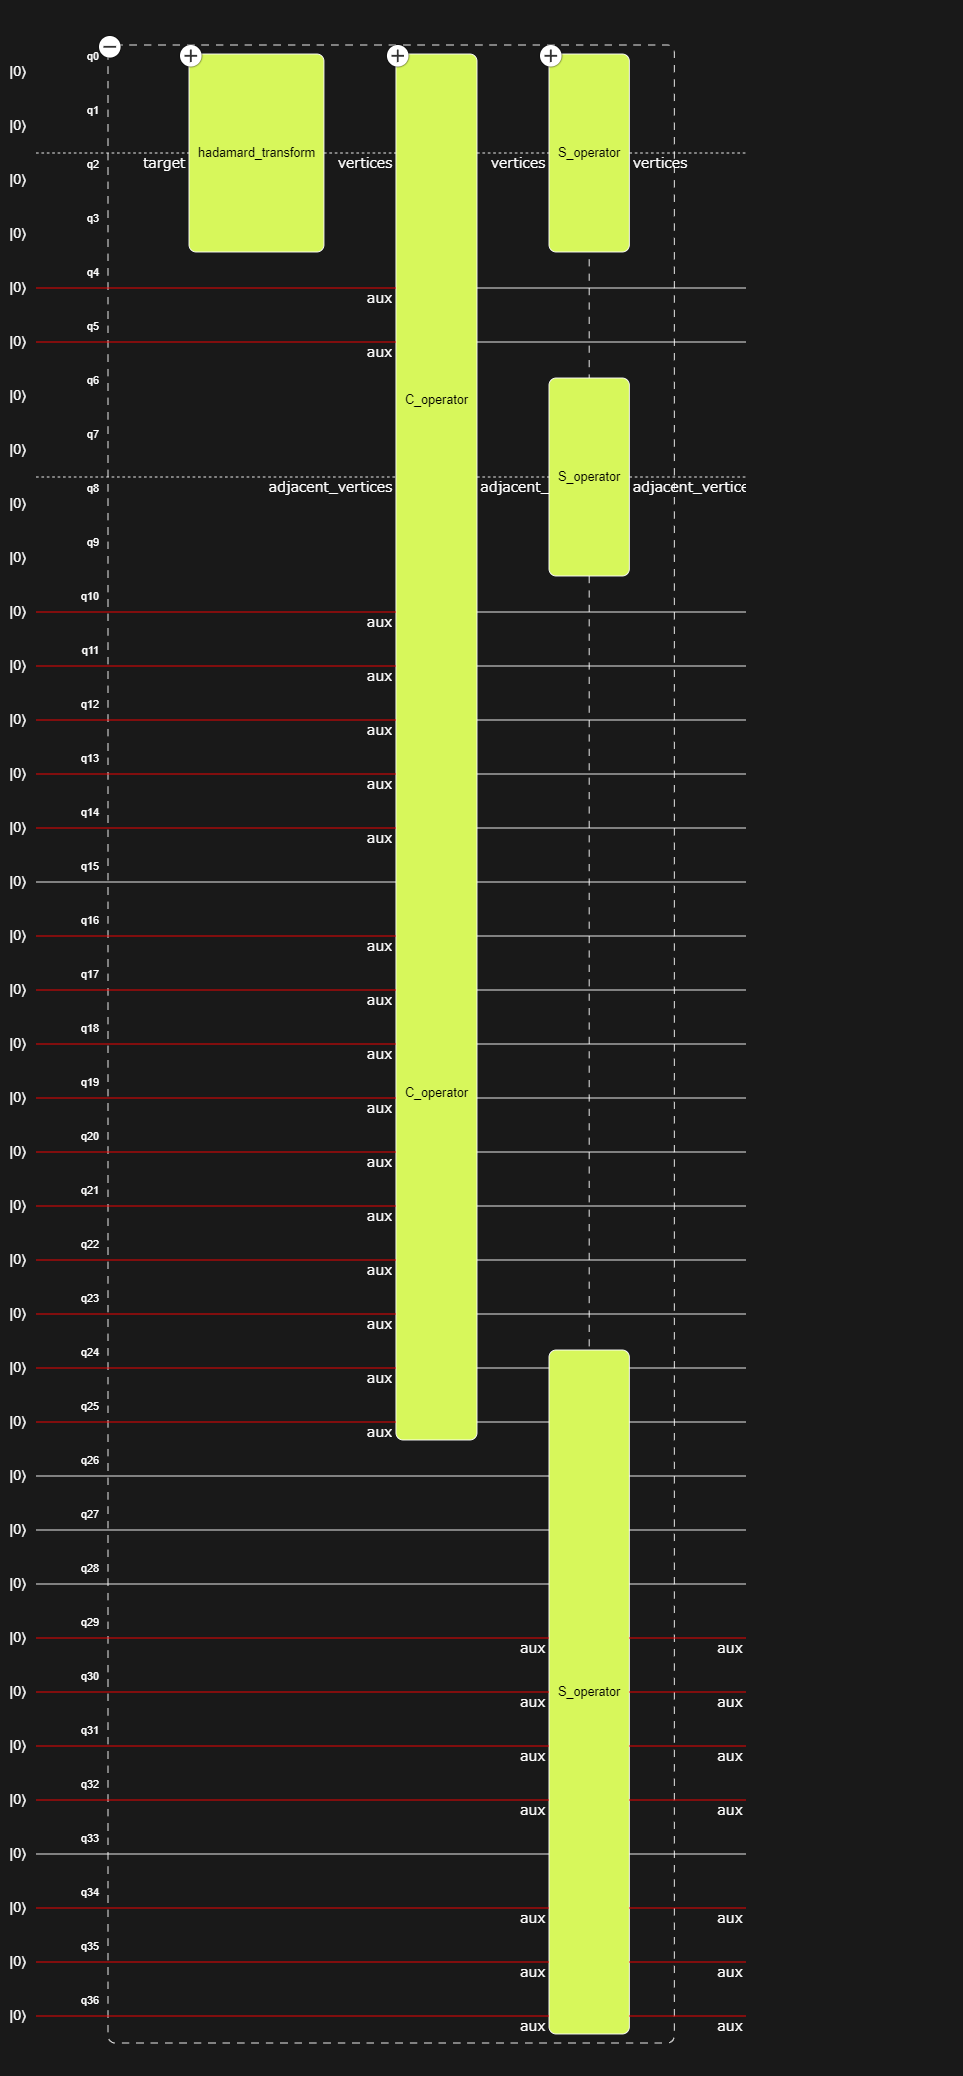